In [1]:
% pylab inline
import os
import random

import pandas as pd
from scipy.misc import imread
from scipy.misc import imresize
import keras
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer,MaxPool2D, Conv2D, Reshape, Dropout,BatchNormalization, Activation
from livelossplot import PlotLossesKeras
from keras.regularizers import l2

Populating the interactive namespace from numpy and matplotlib


/home/manish/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/manish/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/manish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
root_dir = os.path.abspath('.')
data_dir = '/home/manish/my-custom-data/ageDetetction/'
train = pd.read_csv(os.path.join(data_dir+'/train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir+'/test', 'test.csv'))
old=train[train.Class=="OLD"]
train=pd.concat([train,old,old],axis=0,ignore_index=True)
train=train.sample(frac=1)

In [3]:
# converting the image size to 32x32 
training=[]
# training images
for img_name in train.ID:
    path=os.path.join(data_dir,'train/Train',img_name)
#     img=Image.open(path).convert('L').resize((32,32))
    img=Image.open(path).resize((32,32))
    img.dtype=np.float32
    training.append(img)
train_x=np.stack(training)

# test images
test_img=[]
for img_name in test.ID:
    path=os.path.join(data_dir,'test/Test',img_name)
#     img=Image.open(path).convert('L').resize((32,32))
    img=Image.open(path).resize((32,32))
    img.dtype=np.float32
    test_img.append(img)
test_x=np.stack(test_img)


In [4]:
test_x.shape

(6636, 32, 32, 3)

In [5]:
# datagen = ImageDataGenerator()

In [6]:
train_x = train_x / 255.
test_x = test_x / 255.

In [7]:
lb = LabelEncoder()
train_y = lb.fit_transform(train.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

In [8]:
input_num_units = (32, 32, 3)
output_num_units = 3
epochs = 50
batch_size = 128

weight_decay=1e-4

In [9]:
def cnn_model():
    model=Sequential()
    model.add(Reshape(target_shape=(32,32,1)))
    model.add(InputLayer(input_shape=input_num_units))
    model.add(Conv2D(activation='elu',filters=32,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
#     model.add(MaxPool2D(pool_size=2,strides=2))
    model.add(Conv2D(activation='elu',filters=32,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(MaxPool2D(pool_size=2,strides=2))
#     model.add(Conv2D(activation='elu',filters=128,kernel_size=3,padding='same'))
    model.add(Conv2D(activation='elu',filters=64,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Conv2D(activation='elu',filters=64,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(MaxPool2D(pool_size=2,strides=2))
#     model.add(Flatten())
#     model.add(Dense(units=256,activation='relu'))
    model.add(Conv2D(activation='elu',filters=128,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(Conv2D(activation='elu',filters=128,kernel_size=3,padding='same',kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)))
    model.add(MaxPool2D(pool_size=2,strides=2))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))
    return model
    
    

In [10]:

def fconnet():
    model=Sequential()
    model.add(Reshape(target_shape=(32,32,3)))
    model.add(InputLayer(input_shape=input_num_units))
    
    for _ in range(0,3):
        model.add(Conv2D(activation='elu',filters=128,kernel_size=3,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),strides=1))
        model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
        
    model.add(Conv2D(activation='elu',filters=3,kernel_size=3,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),strides=1))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))
    return model

In [11]:
def simple_model():
    model=Sequential()
    model.add(Reshape(target_shape=(32,32,3)))
#     model.add(InputLayer(input_shape=input_num_units))
    model.add(Conv2D(activation='elu',filters=64,kernel_size=3,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02),strides=1,kernel_regularizer=l2(weight_decay)))
    model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(activation='elu',filters=128,kernel_size=3,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02),strides=1,kernel_regularizer=l2(weight_decay)))
    model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
    model.add(Flatten())
    model.add(Dropout(rate=0.5)
    model.add(Dense(activation="elu",units=512,kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(activation="elu",units=1024,kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))
    return model

In [12]:
def simple_model_2():
    model=Sequential()
    model.add(Reshape(target_shape=(32,32,3)))
#     model.add(InputLayer(input_shape=input_num_units))
    model.add(Conv2D(filters=128,kernel_size=5,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),strides=1,kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(filters=128,kernel_size=5,padding='same',
                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),strides=1,kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation(activation="relu"))
    model.add(MaxPool2D(pool_size=2,strides=2,padding='same'))
    model.add(Flatten())
    model.add(Dropout(rate=0.5))
    model.add(Dense(activation="relu",units=512))
    model.add(Dropout(rate=0.5))
    model.add(Dense(activation="relu",units=512))
    model.add(Dropout(rate=0.5))
    model.add(Dense(activation="softmax",units=3))
    return model

In [13]:
import tensorflow as tf
tf.reset_default_graph()
# model=cnn_model()
# model=fconnet()
model=simple_model()

In [14]:
# model.summary()
learning_rate=1e-6
def sch(ep):
    learning_rate/=10
    return learning_rate
lr_schedular=keras.callbacks.LearningRateScheduler(schedule=sch,verbose=1)
earlystop=keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None)
optim=keras.optimizers.Adam(lr=0.001)
learning_rate=0.005
def schedule(epoch):
    if epoch%8==0:
        rate=0.001
    else:
        rate=0.001/(epoch%8)
    return rate
lrschedular=keras.callbacks.LearningRateScheduler(schedule, verbose=0)


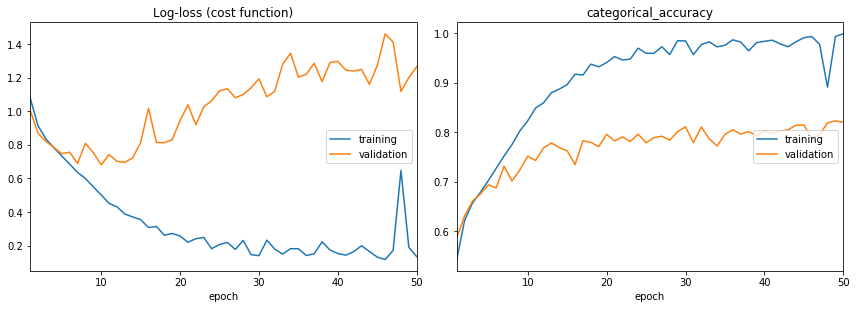

In [15]:
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(train_x, train_y, batch_size=batch_size,epochs=epochs,verbose=1, validation_split=0.2,callbacks=[PlotLossesKeras()])

In [16]:
pred = model.predict_classes(test_x)
pred = lb.inverse_transform(pred)

test['Class'] = pred
test.to_csv("age_detection.csv", index=False)

/home/manish/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
